In [1]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\last\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Se transforman los datos

In [2]:
df = pd.read_csv("df_final.csv")

df = df.drop(columns=['Unnamed: 0',"index","Total libre de impuestos","Indefinido total $","Indefinido ctdad"])
df = df.rename(columns={"date":"Fecha","Encoded Products":"Producto"})
df['Fecha'] = pd.to_datetime(df['Fecha'], format="mixed")
df.columns = df.columns.str.replace("total $", "Precio por unidad")
df.columns = df.columns.str.replace("ctdad", "Cantidad")
def div(numerator, denominator):
  return lambda row: 0.0 if row[denominator] == 0 else float(row[numerator]/row[denominator])
for i in range(2, len(df.columns)-1,2):
    df[df.columns[i]] = df.apply(div(df.columns[i], df.columns[i+1]), axis=1)
#df = df.drop(axis = 0, index = 10865)
df = df.set_index('Fecha')
df["Precio promedio"] = df.iloc[:,1::2].mean(axis=1)
#Decidir si hacerlo antes o despues de elegir variables
df["Dia"] = df.index.day
df["Mes"] = df.index.month



In [3]:
data = pd.DataFrame()
for i in df["Producto"].unique():
        x =pd.DataFrame(df[df["Producto"]==i].loc[:].groupby("Fecha").sum()["Ctdad Ordenada"].asfreq("D", fill_value=0)).rename(columns={"Ctdad Ordenada":i})
        data = pd.concat([data,x], axis=1)
data.fillna(0, inplace=True)
data

,Producto 11,Producto 117,Producto 8,Producto 16,Producto 79,Producto 105,Producto 43,Producto 12,Producto 20,Producto 37,...,Producto 208,Producto 206,Producto 207,Producto 205,Producto 204,Producto 203,Producto 202,Producto 201,Producto 272,Producto 273
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-02,10.5,3.5,21.0,3.5,3.5,3.5,3.5,7.0,3.5,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03,3.5,0.0,0.0,3.5,0.0,0.0,0.0,10.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,7.0,0.0,10.5,3.5,0.0,0.0,0.0,3.5,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,0.0,0.0,10.5,3.5,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-06,0.0,0.0,3.5,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,0.0,17.5,3.5,0.0,0.0,0.0,3.5,0.0,0.0,...,10.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381.5
2023-12-28,0.0,0.0,21.0,10.5,0.0,0.0,0.0,3.5,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448.0
2023-12-29,0.0,0.0,31.5,21.0,0.0,0.0,0.0,3.5,0.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0


<Axes: >

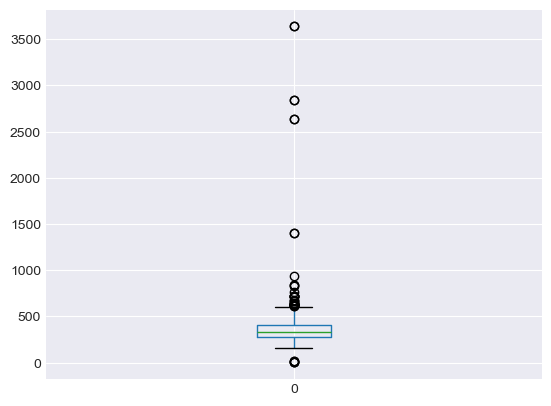

In [4]:
boxdf = pd.DataFrame(data.sum(axis=1))
boxdf.boxplot()

# Se eliminan los datos con menos de 50 ventas en el ultimo año

In [5]:
for i in data.columns:
    if data.loc["2023-01-01":,i].sum() < 50:
        data = data.drop(columns=i,axis=1)
    

In [13]:
data

,Producto 8,Producto 16,Producto 79,Producto 43,Producto 12,Producto 20,Producto 37,Producto 5,Producto 0,Producto 1,...,Producto 182,Producto 150,Producto 122,Producto 148,Producto 131,Producto 134,Producto 208,Producto 201,Producto 272,Producto 273
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-02,21.0,3.5,3.5,3.5,7.0,3.5,7.0,14.0,10.5,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03,0.0,3.5,0.0,0.0,10.5,0.0,0.0,21.0,38.5,17.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,10.5,3.5,0.0,0.0,3.5,3.5,3.5,21.0,56.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,10.5,3.5,0.0,0.0,7.0,0.0,0.0,10.5,49.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-06,3.5,7.0,0.0,0.0,7.0,0.0,0.0,10.5,17.5,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,17.5,3.5,0.0,0.0,3.5,0.0,0.0,28.0,45.5,45.5,...,0.0,3.5,0.0,3.5,0.0,0.0,10.5,0.0,0.0,381.5
2023-12-28,21.0,10.5,0.0,0.0,3.5,3.5,0.0,10.5,28.0,17.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448.0
2023-12-29,31.5,21.0,0.0,0.0,3.5,0.0,0.0,38.5,35.0,31.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,336.0


# Se divide el test en validacion, test y entrenamiento

In [14]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2023-10-21'
end_val = '2023-11-30'

data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-02 00:00:00 --- 2023-10-21 00:00:00  (n=658)
Validation dates : 2023-10-21 00:00:00 --- 2023-11-30 00:00:00  (n=41)
Test dates       : 2023-11-30 00:00:00 --- 2023-12-31 00:00:00  (n=32)


Algunas de los trends que hay

In [15]:
# Plot time series
# ======================================================================================
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    title    = 'Sales of store 2',
    ax       = ax, 
)
fig.tight_layout();

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_33820\27394305.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


In [10]:
from tqdm import tqdm
from functools import partialmethod

## CORRER BAJO TU PROPIO RIESGO, toma una hora encontrar los mejores hiperparametros para todas las series

In [19]:
# Hyperparameter search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []
dictes = {}

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1]
}

for i, item in enumerate(data.columns):

    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, item],
                       lags_grid          = lags_grid,
                       param_grid         = param_grid,
                       steps              = 7,
                       metric             = 'mean_squared_error',
                       initial_train_size = len(data_train),
                       refit              = False,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False,
                       show_progress      = False 
                  )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = ['mean_squared_error', 'mean_absolute_percentage_error'],
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    dictes[item] = results_grid
    

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

Number of models compared: 48.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 20.571478837970684

Number of models compared: 48.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 2.3696279606808597

Number of models compared: 48.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.1, 'max_depth': None, 'max_iter': 500}
  Backtesting metric: 6.621851762226922

Number of models compared: 48.
`Forecaster` refitted using the best-found lags

# Se procede a hacer un modelo para cada uno de ellos. Será necesario obtener las medidas de error para cada uno de ellos. 

In [22]:
uni_series_mae[uni_series_mae < 1].index

TypeError: '<' not supported between instances of 'list' and 'int'

En esos csv estan los parametros y los resultados de MAPE que dieron

In [28]:
for i in dictes.keys():
    dictes[i].to_csv(f"dictes_{i}.csv")

In [27]:
dictes["Producto 101"]

,lags,params,mean_squared_error,learning_rate,max_depth,max_iter
47,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': None, 'max...",2.069622,0.10,NaN,500.0
45,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",2.098394,0.10,10.0,500.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': None, 'max...",2.323072,0.10,NaN,500.0
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",2.458986,0.10,10.0,500.0
43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'max_it...",2.538598,0.10,5.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 5, 'max_it...",2.635012,0.10,5.0,500.0
41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",2.847323,0.10,3.0,500.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",2.878149,0.10,3.0,500.0
44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",2.940070,0.10,10.0,100.0
46,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': None, 'max...",2.964621,0.10,NaN,100.0


In [9]:
dic0 = pd.read_csv("0.csv")
dic273 = pd.read_csv("273.csv")

NameError: name 'dictes' is not defined

In [279]:
dictes["Producto 273"]

,lags,params,mean_absolute_percentage_error,learning_rate,max_depth,max_iter
43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'max_it...",0.123255,0.10,5.0,500.0
47,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': None, 'max...",0.179854,0.10,NaN,500.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': None, 'max...",0.201374,0.10,NaN,500.0
45,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.209886,0.10,10.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 5, 'max_it...",0.229158,0.10,5.0,500.0
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.232482,0.10,10.0,500.0
41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.245357,0.10,3.0,500.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.250662,0.10,3.0,500.0
13,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.385138,0.10,10.0,500.0
15,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': None, 'max...",0.386888,0.10,NaN,500.0


Asi se hace un modelo

In [29]:
forecaster = ForecasterAutoreg(
    regressor=HistGradientBoostingRegressor(random_state=123, max_iter=500, max_depth=10, learning_rate=0.1),
    lags=14,
    transformer_y=StandardScaler()
)                    

# Como se ve el producto 0 con su predicción y los datos originales

In [30]:
forecaster.fit(y = data_train["Producto 0"].loc[:end_train])

In [36]:
data["Producto 0"].loc["2023-11-22":"2023-11-28"]

Fecha
2023-11-22    21.0
2023-11-23    10.5
2023-11-24    10.5
2023-11-25    52.5
2023-11-26    21.0
2023-11-27    45.5
2023-11-28    14.0
Freq: D, Name: Producto 0, dtype: float64

In [ ]:
forecaster.predict(50).loc["2023-11-22":"2023-11-28"]

## Agregar modelo del otro producto y comparar

In [55]:
predicts=forecaster.predict(len(data_test))

In [58]:
resid = data["Producto 0"].loc["2023-10-21":"2023-10-28"] - predicts